# Data Tigers
## Team 30

This script was used to construct a scikit-learn pipeline to optimize a classification model. This pipeline lets us separately process the categorical and numerical data, as well as try many different combinations of data preprocessing and model hyperparameters.

In [44]:

# !pip install xgboost
# !pip install imbalanced-learn
# !pip install lightgbm

In [93]:
from typing import Any, Union
from pathlib import Path


import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    make_scorer
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
# from sklearn.experimental import enable_hist_gradient_boosting

from datetime import timedelta

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score


from sklearn.ensemble import HistGradientBoostingClassifier
#import lightgbm

from imblearn.pipeline import Pipeline as Pipeline_imb

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt


import os

pd.set_option("display.max_columns", None)


In [3]:
class PipelineManager:
    def __init__(self, estimator: str):
        # estimator should be regressor or classifier
        if estimator.lower() not in ["regressor", "classifier"]:
            raise ValueError(
                f"Estimator should be regressor or classifier, got: {estimator}"
            )
        self.estimator = estimator.lower()
        self.pipeline = None
        self.cat_features = []
        self.num_features = []
        self.param_grids = []
        self.best_estimator = None

    def set_categorical_features(self, cat_features: list):
        """Sets the categorical features that can be used by the ML model.

        Args:
            cat_features (list): List of categorical features to be passed to
            the model.
        """
        self.cat_features = cat_features

    def set_numerical_features(self, num_features: list):
        """Sets the numerical features that can be used by the ML model.

        Args:
            num_features (list): List of numerical features to be passed to the
            model.
        """
        self.num_features = num_features


    def set_basic_pipeline(self):
        """Defines the pipeline that will be used as the base on which to build
        the rest of the pipeline parameters.

        Raises:
            ValueError: If the estimator, when the class was initialized, was
            not regressor nor classifier.
        """
        if self.estimator == "regressor":
            base_estimator = RandomForestRegressor()
        elif self.estimator == "classifier":
            base_estimator = RandomForestClassifier()
        else:
            raise ValueError(
                f"Estimator should be regressor or classifier, got: {self.estimator}"
            )
        numeric_preprocessor = Pipeline(
            steps=[
                (
                    "imputer",
                    SimpleImputer(missing_values=np.nan, strategy="mean"),
                ),
                ("scaler", StandardScaler()),
            ]
        )

        categorical_preprocessor = Pipeline(
            steps=[
                (
                    "imputer",
                    SimpleImputer(fill_value="missing", strategy="constant"),
                ),
                ("encoder", OneHotEncoder(drop='first',handle_unknown="ignore")),
            ]
        )

        

        preprocessor = ColumnTransformer(
            [
                ("categorical", categorical_preprocessor, self.cat_features),
                ("numerical", numeric_preprocessor, self.num_features),
            ]
        )

        self.pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("feature_selector", SelectFromModel(RandomForestRegressor())),
                ("estimator", base_estimator),
            ]
        )

    def get_default_param_grid(self) -> dict:
        """Creates the default parameter grid for the pipeline manager.

        This default parameter grid contains the base hyperparameters to tune.

        Returns:
            dict: Dictionary containing the different named steps as the keys
            and their respective tune values/methods.
        """
        param_grid = {

            "preprocessor__numerical__scaler": [
                StandardScaler(),
                RobustScaler(),
                MinMaxScaler(),
                Normalizer(),
                # PowerTransformer(),
            ],

            "feature_selector": [
                # SelectFromModel(Lasso()),
                SelectFromModel(ElasticNet()),
                SelectFromModel(Ridge()),
                VarianceThreshold(),
            ],
        }
        return param_grid

    @staticmethod
    def convert_dict_names(param_grid: dict) -> dict:
        """Converts the dictionary keys into the named_steps format

        Converts the keys of the passed dictionary into the named_steps format,
        assuming that any key in the dictionary that does not contain a double
        underscore ('__') is a parameter to be passed to the estimator. If the
        key already contains a double score, it is left untouched assuming it
        already is in the named steps format required for hyperparameter tuning.

        Args:
            param_grid (dict): Dictionary with the extra hyperparameters to add
            to the default hyperparameter grid.

        Returns:
            dict: A copy of the modified keys in the named steps format.
        """
        return {
            f"estimator__{key}": value
            for key, value in param_grid.items()
            if "__" not in key
        }

        
        
    def add_estimator(self, estimator: BaseEstimator, param_grid: dict):
        """Adds the estimator and its parameter grid to the list of estimators.

        The keys of the param_grid dictionary will be converted into the
        named_steps format, assuming that any key in the dictionary that does
        not contain a double underscore ('__') is a parameter to be passed to
        the estimator. If the key already contains a double score, it is left
        untouched assuming it already is in the named steps format required for
        hyperparameter tuning.

        Args:
            estimator (BaseEstimator): Estimator to be used as a
                classifier/regressor.
            param_grid (dict): Hyperparameter dictionary.
        """
        param_dict = {}
        param_dict.update(self.get_default_param_grid())
        param_dict.update(self.convert_dict_names(param_grid))
        param_dict.update({"estimator": [estimator]})
        self.param_grids.append(param_dict)

    def find_best_model(
        self, X: Any, y: Any, cv: int = 5, n_jobs: int = -1, n_iter: int = -1, **kwargs
    ) -> BaseEstimator:
        """Finds the best estimator from the previousl passed hyperparameter space.

        This function will run a full GridSearch or a RandomizedSearch, based on
        the n_iter parameter, to find the best performing estimator from the
        default hyperparameter space it has and any extra parameters passed when
        adding estimators.

        Args:
            X (Any): {array-like, sparse matrix} of shape
                (n_samples, n_features). Data to be used for training.
            y (Any): array-like of shape (n_samples,). Data containing the
                target values/classes.
            cv (int, optional): Number of folds for the K-fold cross validation.
                Defaults to 5.
            n_jobs (int, optional): Number of workers to use for parallelization.
                A negative value indicates an all but #, e.g. -1 means all
                processors, -2 means all but 1 processor, etc. Defaults to -1.
            n_iter (int, optional): Number of combinations to try for the
                hyperparameter tuning. A value 0f -1 indicates that ALL of the
                hyperparameter feature space will be tested. Defaults to -1.

        Returns:
            BaseEstimator: Best pipeline with the tuned hyperparameters.
        """
        if self.pipeline is None:
            self.set_basic_pipeline()
        param_grids = self.param_grids

        if kwargs.get("fit_params"):
            fit_params = kwargs.get("fit_params")
            del kwargs["fit_params"]
        else:
            fit_params = {}

        if n_iter == -1:
            # Do a full search of the feature space
            self.hyperparameter_tuner = GridSearchCV(
                self.pipeline,
                param_grids,
                cv=cv,
                n_jobs=n_jobs,
                **kwargs,
            )
        else:
            # Do a randomized search of the feature space, looking for n_iter combinations
            self.hyperparameter_tuner = RandomizedSearchCV(
                self.pipeline,
                param_grids,
                n_iter=n_iter,
                cv=cv,
                n_jobs=n_jobs,
                **kwargs,
            )

        self.hyperparameter_tuner.fit(X, y, **fit_params)
        self.cv_results = pd.DataFrame(self.hyperparameter_tuner.cv_results_)

        self.best_estimator = self.hyperparameter_tuner.best_estimator_
        self.best_params = self.hyperparameter_tuner.best_params_
        return self.best_estimator

    def score(
        self, X: Any, y_true: Any, as_frame: bool = True
    ) -> Union[dict, pd.DataFrame]:
        """Runs different metrics through the model to test its performance.

        The metrics are defined based on if the model is a classifier or a
        regressor. returns a DataFrame if as_frame is True, else it returns a
        dictionary.

        Args:
            X (Any): {array-like, sparse matrix} of shape
                (n_samples, n_features). Data to be used for predicting results.
            y_true (Any): array-like of shape (n_samples,). Response data for
                the passed X.
            as_frame (bool, optional): If True, the return of the function will
                be a DataFrame instead of a dictionary. Defaults to True.

        Raises:
            ValueError: If the pipeline has not been fitted, i.e. if
                find_best_model() has not been run.

        Returns:
            Union[dict, pd.DataFrame]: Dictionary or DataFrame containing the
                results of running the different metrics.
        """

        if self.best_estimator is None:
            raise ValueError("Pipeline has not been fitted")
        score = {}
        y_score = self.best_estimator.predict(X)
        if self.estimator == "classifier":
            try:
                y_proba = self.best_estimator.predict_proba(X)
                if y_proba.shape[1]<=2:
                    y_proba = y_proba[:, 1]
                    score["ROC_AUC"] = roc_auc_score(
                        y_true, y_proba
                    )
                else:
                    score["ROC_AUC"] = roc_auc_score(
                        y_true, y_proba, multi_class="ovo"
                    )
            except:
                score["ROC_AUC"] = "NA"
            score["accuracy"] = accuracy_score(y_true, y_score)
            score["balanced_accuracy"] = balanced_accuracy_score(y_true, y_score)
            for measurement in ["micro", "macro", "weighted"]:
                score[f"{measurement}_f1_score"] = f1_score(
                    y_true, y_score, average=measurement
                )
            try:
                score["confusion_matrix"] = confusion_matrix(y_true, y_score)
            except:
                score["confusion_matrix"] = "NA"
                
            try:
                score['geometric_mean_score'] = geometric_mean_score(y_true, y_score, average='binary')
            except:
                score['geometric_mean_score'] = 'NA'
            
            try:
                score["confusion_matrix_normalized"] = confusion_matrix(
                    y_true, y_score, normalize="all"
                )
            except:
                score["confusion_matrix_normalized"] = "NA"
                
            try:
                score["classification_report"] = pd.DataFrame(
                    classification_report(y_true, y_score, output_dict=True)
                ).transpose()
            except:
                score["classification_report"] = "NA"
                


        elif self.estimator == "regressor":
            score["R2"] = r2_score(y_true, y_score)
            score["MSE"] = mean_squared_error(y_true, y_score)
            score["RMSE"] = mean_squared_error(y_true, y_score, squared=False)

        if as_frame:
            score = pd.DataFrame.from_dict(score, orient="index").T
        return score





### Load data
Data was already processed in the following format:
- Created sensors_df from precipitation, pressure and temeprature dataset by merging using an inner join on 'codigo_estacion', 'nombre_estacion', 'departamento', 'municipio', 'anio_observacion', 'doy_observacion', 'day_observacion', 'mes_observacion', 'DIVIPOLA', 'zona_hidrografica'
- dropped duplicate in emergencies where emergencies_df.drop_duplicates(subset = ['FECHA','DIVIPOLA']).
- created new colum `fecha_observacion_delay1` on the emergencies dataset by reducing one day from colum `FECHA`.
- merged sensord_df with emergencies left_on=['anio_observacion','doy_observacion','day_observacion','mes_observacion', 'DIVIPOLA'], right_on=['anio_observacion_delay1','doy_observacion_delay1','day_observacion_delay1','mes_observacion_delay1', 'DIVIPOLA'],
                                  


In [27]:
datasets_dir = Path.cwd().parent.parent/'data'/'Datasets'
sensors_emergencies_df = pd.read_pickle(datasets_dir/ 'sensors_emergencies.pkl')
#sensors_emergencies_df = pd.read_pickle(os.sep.join(['Datasets', 'sensors_emergencies.pkl']))

### Keep only data where T1440 max is greater than 0

In [28]:
sensors_emergencies_df = sensors_emergencies_df.loc[sensors_emergencies_df['T1440_max'] > 0].copy()
sensors_emergencies_df.shape

(189427, 101)

In [29]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
smote = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', smote), ('u', under)]
pipeline_sampling_smote_under = Pipeline_imb(steps=steps)


In [30]:
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline_sampling_over_under = Pipeline_imb(steps=steps)

In [31]:
sampler_dic = {'oversample':RandomOverSampler, 
               'undersample':RandomUnderSampler, 
               'smote':SMOTE, #Use with numerical data only 
               'smote_under':pipeline_sampling_smote_under, #Use with numerical data only 
               'over_under':pipeline_sampling_over_under
              }


In [32]:
sensors_emergencies_df.loc[(sensors_emergencies_df['emergency']), 'municipio'].value_counts().head(17)

BOGOTÁ. D.C.           48
PEREIRA                35
VILLAVICENCIO          26
SANTA MARTA            20
CALI                   15
MONTERÍA               14
BARBACOAS              14
SAN JOSÉ DE CÚCUTA     12
VALLEDUPAR             12
PASTO                  10
JAMUNDÍ                10
RIOHACHA                9
QUIBDÓ                  9
IBAGUÉ                  8
MEDELLÍN                8
SARAVENA                8
BOJAYÁ (BELLAVISTA)     8
Name: municipio, dtype: int64

In [33]:
municipios_list = list(sensors_emergencies_df.loc[(sensors_emergencies_df['emergency']), 'municipio'].value_counts().head(17).index)
municipios_list

# sensors_emergencies_df.loc[(sensors_emergencies_df['emergency']), 'municipio'].value_counts().head(17)

['BOGOTÁ. D.C.',
 'PEREIRA',
 'VILLAVICENCIO',
 'SANTA MARTA',
 'CALI',
 'MONTERÍA',
 'BARBACOAS',
 'SAN JOSÉ DE CÚCUTA',
 'VALLEDUPAR',
 'PASTO',
 'JAMUNDÍ',
 'RIOHACHA',
 'QUIBDÓ',
 'IBAGUÉ',
 'MEDELLÍN',
 'SARAVENA',
 'BOJAYÁ (BELLAVISTA)']

In [86]:
if __name__ == "__main__":
    # Example usage of the pipeline for a classification problem
#     SELECT SAMPLING METHODS
#     balance_classes = 'over_under'
#     balance_classes = 'smote_under'
#    balance_classes = 'undersample'
    balance_classes = 'oversample'
#     balance_classes = 'smote'
#     'undersample'
    
#     CREATE LIST OF METHODS TO ADD TO TEST IN PIPELINE
    models = ['xgbooster', 'random_forest'] #'lightgbm', 
#     methods = ['xgboost', 'lightgbm']
    
    pipeline = PipelineManager(estimator="classifier")

#     SELECT CATEGORICAL FEATURES
    cat_features = [
                            'zona_hidrografica', 
                            'DIVIPOLA', 
    ]
#     SELECT NUMERICAL FEATURES
    num_features = [

                            'doy_observacion_sensor',
                            'mes_observacion_sensor',
                            'valor_observado_avg_temperature',
                            'valor_observado_min_temperature',
                            'valor_observado_max_temperature',
                            'valor_observado_avg_pressure',
                            'valor_observado_min_pressure',
                            'valor_observado_max_pressure',
                            'latitud',
                            'longitud',
                            'valor_observado_avg',
                            'valor_observado_min',
                            'valor_observado_max',
                            'T10_max',
                            'T30_max',
                            'T60_max',
                            'T120_max',
                            'T360_max',
                            'T720_max',
                            'T1080_max',
                            'T1440_max'
    ]
    
        
#     All municipios in Colombia
    X = sensors_emergencies_df.copy()

    Y = sensors_emergencies_df['emergency']

    #     SET CATEGORICAL FEATURES AS CATEGORICAL
    for cat_col in cat_features:
        X[cat_col] = X[cat_col].astype('str').astype('category')

    X_train = X[X['anio_observacion_sensor']<2021]
    X_test = X[X['anio_observacion_sensor']==2021]
    
    y_train = X_train['emergency']
    y_test = X_test['emergency']
    
    X_train = X_train.drop('emergency', axis=1)
    X_test = X_test.drop('emergency', axis=1)
    
    


#     SPLIT DATA
    #cutoff_year = 2021
    #X_train = sensors_emergencies_df.loc[(sensors_emergencies_df['anio_observacion_sensor'] < cutoff_year) 
    #                                     & (sensors_emergencies_df['municipio'].isin(municipios_list))
    #                                    ]
    #y_train = sensors_emergencies_df.loc[(sensors_emergencies_df['anio_observacion_sensor'] < cutoff_year) 
    #                                     & (sensors_emergencies_df['municipio'].isin(municipios_list))
    #                                     , 'emergency']

    #X_test = sensors_emergencies_df.loc[(sensors_emergencies_df['anio_observacion_sensor'] == cutoff_year) 
    #                                    & (sensors_emergencies_df['anio_observacion_sensor'] <2022) 
    #                                    &(sensors_emergencies_df['municipio'].isin(municipios_list))
    #                                   ]
    #y_test = sensors_emergencies_df.loc[(sensors_emergencies_df['anio_observacion_sensor'] == cutoff_year) 
    #                                    & (sensors_emergencies_df['anio_observacion_sensor'] <2022) 
    #                                    &(sensors_emergencies_df['municipio'].isin(municipios_list))
    #                                 , 'emergency']
#     KEEP COLUMNS OF INTEREST
    try:
        assert (set(X.columns)-set(num_features)-set(cat_features))==set([])
    except:
        all_cols = []+num_features+cat_features
        X = X[all_cols]
        X_train = X_train[all_cols]
        X_test = X_test[all_cols]
    
    
# UNCOMMENT TO KEEP ONLY NUMERICAL DATA
#    X = X[num_features]    
#    X_train = X_train[num_features]
#    X_test = X_test[num_features]
#    pipeline.set_numerical_features(X.columns)

    X = X[all_cols]    
    X_train = X_train[all_cols]
    X_test = X_test[all_cols]
    
    
#     SET PIPELINE FEATURES
    pipeline.set_categorical_features(X[cat_features].columns)
    pipeline.set_numerical_features(X[num_features].columns)
    
#     KEEP COLUMNS OF INTEREST
    try:
        assert (set(X.columns)-set(num_features)-set(cat_features))==set([])
    except:
        all_cols = []+num_features+cat_features
        X = X[all_cols]
        X_train = X_train[all_cols]
        X_test = X_test[all_cols]
    
    if balance_classes:
        print(f'Balancing: {balance_classes}')
        
        if not balance_classes in ['under_smote', 'over_under']:
            sampler = sampler_dic[balance_classes](random_state=42)
        elif balance_classes in ['under_smote', 'over_under']:
            sampler = sampler_dic[balance_classes]
            
        if balance_classes == 'smote':
            X_train = X_train.dropna()
            y_train = y_train.loc[X_train.index]
        
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if 'KNN' in models:
        param_grid = {
            "n_neighbors": np.arange(3, 15, 2, dtype=int),
            "p": np.linspace(1, 10, 5, dtype=int),
            "weights": ["uniform", "distance"],
        }
        estimator = KNeighborsClassifier()
        pipeline.add_estimator(estimator, param_grid)


    if 'random_forest' in models:
        param_grid = {
            "n_estimators": np.linspace(1, 100, 10, dtype=int),
            "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
            "bootstrap": [True, False],
        }
        estimator = RandomForestClassifier(random_state=42)
        pipeline.add_estimator(estimator, param_grid)

    if 'xgbooster' in models:
        param_grid = {
            'min_child_weight': sp_randInt(1, 10),
            'gamma': sp_randFloat(0.5, 5),
            'subsample': sp_randFloat(0.5, 1.0),
            'colsample_bytree': sp_randFloat(0.5, 1.0),
            'max_depth': sp_randInt(3, 5)
            #"n_estimators": np.linspace(11, 101, 10, dtype=int),
            #"max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
            #"bootstrap": [True, False],
    #         "learning_rate":[],
            #'scale_pos_weight': np.concatenate([[1],np.linspace(100, 400, 4, dtype=float)])       
        }

        estimator = XGBClassifier(random_state=42)

        pipeline.add_estimator(estimator, param_grid)
    
    if 'hist_gradient_booster' in models:
    ## HistGradientBoostingClassifier    
        param_grid = {
            "max_iter": np.linspace(10, 100, 10, dtype=int),
            "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    #         "bootstrap": [True, False],
    #         "learning_rate":[],
    #         'scale_pos_weight': np.concatenate([[1],np.linspace(100, 400, 4, dtype=float)])
        }

        estimator = HistGradientBoostingClassifier(random_state=42)

        pipeline.add_estimator(estimator, param_grid)

    if 'lightgbm' in models:
# # # lightgbm

        param_grid = {
            "num_leaves": list(np.linspace(2, 10, 5, dtype=int)) + [None],
            "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    #         "bootstrap": [True, False],
    #         "learning_rate":[],
            'is_unbalance':[None,True],
    #         'scale_pos_weight': np.concatenate([[1],np.linspace(10, 200, 10, dtype=float)])
        }

        from lightgbm import LGBMClassifier

        estimator = LGBMClassifier(random_state=42, 
    #                                is_unbalance = True
                                  )
    
        pipeline.add_estimator(estimator, param_grid)
    
    gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True, average='binary')

    scoring = {'geometric_mean_score':gm_scorer}
    best_model = pipeline.find_best_model(X_train, y_train, cv=5, 
                                          n_iter=1000, 
#                                           scoring = 'balanced_accuracy'
#                                           scoring = 'f1_weighted'
#                                           scoring = 'roc_auc'
                                           scoring = gm_scorer,
#                                           refit = 'geometric_mean_score'
                                         )
    score = pipeline.score(X_test, y_test)
    print("Done!")

Balancing: oversample
[21:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\david\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Done!


In [87]:
geometric_mean_score(y_test, best_model.predict(X_test), average='binary')

C:\Users\david\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.5490823157219105

In [88]:
# DISPLAY CROSS VALIDATION RESULTS
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_score"]).head(30))
    

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__numerical__scaler,param_feature_selector,param_estimator__scale_pos_weight,param_estimator__n_estimators,param_estimator__max_depth,param_estimator__bootstrap,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,70.123474,5.160876,0.549095,0.099036,MinMaxScaler(),SelectFromModel(estimator=Ridge()),400.0,81,3,True,"XGBClassifier(base_score=None, booster=None, b...",{'preprocessor__numerical__scaler': MinMaxScal...,0.67563,0.68112,0.684863,0.604173,0.488161,0.626789,0.075417,1


In [89]:
# CHECK BEST HYPERPARAMETERS

pipeline.hyperparameter_tuner.best_params_


{'preprocessor__numerical__scaler': MinMaxScaler(),
 'feature_selector': SelectFromModel(estimator=Ridge()),
 'estimator__scale_pos_weight': 400.0,
 'estimator__n_estimators': 81,
 'estimator__max_depth': 3,
 'estimator__bootstrap': True,
 'estimator': XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=81, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=42,
               reg_alpha=None, ...)}

In [90]:
# CHECK PERFORMANCE SCORES
score


,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,geometric_mean_score,confusion_matrix_normalized,classification_report
0,0.594291,0.506041,0.550941,0.506041,0.33971,0.668811,"[[15099, 14757], [42, 62]]",0.549082,"[[0.5039719626168224, 0.4925567423230975], [0....",precision recall f1-score ...


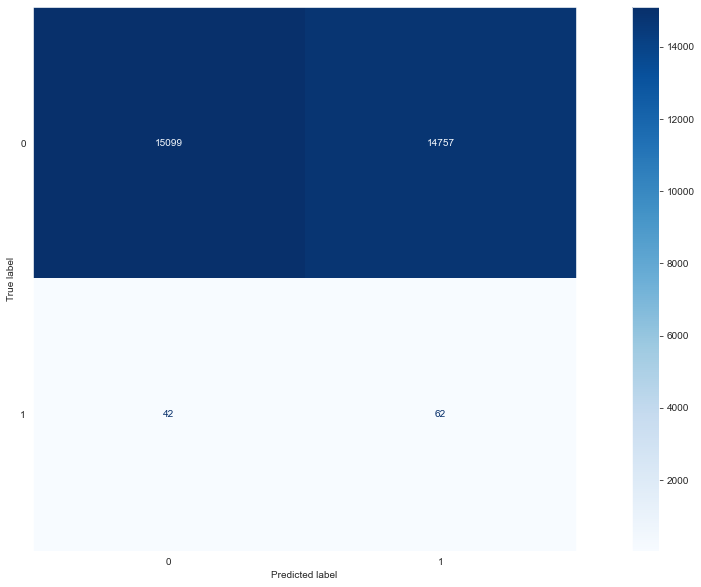

In [91]:
# PLOT CONFUSION MATRIX
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

score.loc[0,'classification_report'].round(2)
with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
#                                 display_labels=labels_decoded
#                                   cmap ='blues'
                                 )
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.show()


C:\Users\david\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


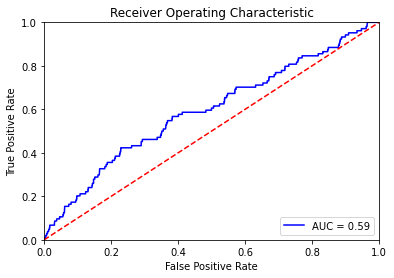

In [92]:
# PLOT ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipeline.hyperparameter_tuner.best_estimator_.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [271]:
# SAVE MODEL
# from joblib import dump
# dump(pipeline.hyperparameter_tuner.best_estimator_,'/home/jovyan/data/models/_lightgbm_none_gmscorer_municipios.pickle')

['/home/jovyan/data/models/5_xgboost_under_rocauc.pickle']